In [143]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from scipy.stats import lognorm
from tqdm import tqdm

In [144]:
# Read the BBBP dataset
df = pd.read_csv("BBBP.csv")

# Drop rows with missing values
df = df.dropna()

# Print 10 random SMILES strings
print(df.sample(10)["smiles"].values)

['C1=C(C2=C(C=C1)OCCO2)N3CCNCC3'
 '[C@@H]34C1=CC=CC2=C1C(=C[NH]2)C[C@H]3N(C[C@H](C4)N[S](N(CC)CC)(=O)=O)C'
 '[C@H]34[C@H]2[C@@H]([C@@]1(C(=CC(=O)CC1)CC2)C)[C@@H](O)C[C@@]3([C@](C(CS)=O)(O)CC4)C'
 'COc1cc(cc(OC)c1O)[C@H]2[C@@H]3[C@H](COC3=O)[C@H](OC4OC5COC(OC5C(O)C4O)c6sccc6)c7cc8OCOc8cc27'
 'C1=C(O)C=CC4=C1C3(C(C(N(CC2CC2)CC3)C4)(C)C)CC'
 '[Na+].[Na+].[Na+].[O-]C(=O)[P]([O-])([O-])=O'
 'C1=C(C(=CC=C1Cl)N(C(CN(CCO)CCO)=O)C)C(C2=C(C=CC=C2)Cl)=O'
 'Cc1ncc(n1CCO)[N+]([O-])=O' 'CC1OC(C)OC(O1)C' 'CNC1(CCCCC1=O)c2ccccc2Cl']


SMILES stands for Simplified Molecular-Input Line-Entry System. It's a way to represent molecules using letters, numbers, and symbols. Here's an example for water (H2O):
O=H-H

The O means there is an oxygen atom. The = connects the oxygen to a hydrogen atom. The - connects the oxygen to another hydrogen atom. So O=H-H shows the 2 hydrogen atoms bonded to the oxygen, just like in a water molecule!

SMILES uses simple rules so we can write down many kinds of molecules easily on a computer. We don't have to draw pictures of the molecules every time. SMILES lets us store and share information about molecules using text.

<Axes: >

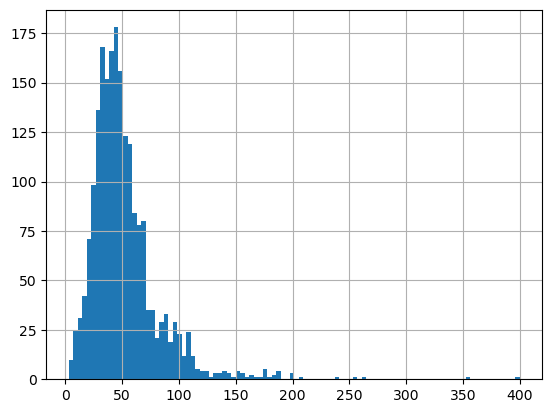

In [145]:
# Show the SMILES strings length distribution
df["smiles"].str.len().hist(bins=100)

It looks like SIMLES string in given dataset has some kind of Gamma or Normal distribution. Let's check it out.

shape: 0.43196109015880996, loc: -9.831977949438091, scale: 55.64928070973342


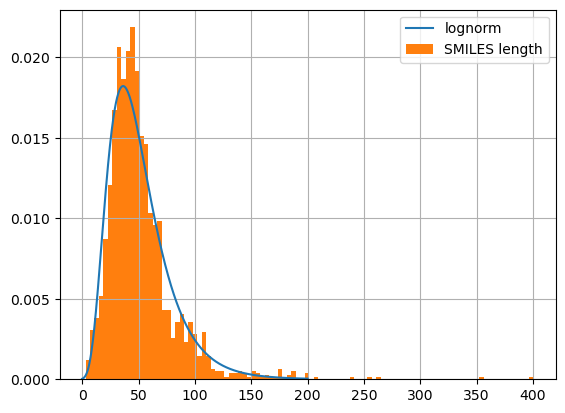

In [146]:
# Fit lognormal distribution to the SMILES strings length distribution
shape, loc, scale = lognorm.fit(df["smiles"].str.len())
print(f"shape: {shape}, loc: {loc}, scale: {scale}")

# Plot the SMILES strings length distribution and the fitted lognormal distribution
x = np.linspace(0, 200, 1000)
plt.plot(x, lognorm.pdf(x, shape, loc, scale), label="lognorm")
df["smiles"].str.len().hist(bins=100, density=True, label="SMILES length")
plt.legend()
plt.show()



It looks like SIMLES string has log-normal distribution. At least for me :)

In [147]:
# Tokenize the SMILES string based on the defined regex pattern
# I Got the regex from my friend
def tokenizer(smiles_string):

  # Define the SMILES regex pattern
  SMI_REGEX_PATTERN = r"""(\[[^\]]+]|Br?|Cl?|N|O|S|P|F|I|b|c|n|o|s|p|\(|\)|\.|=|#|-|\+|\\|\/|:|~|@|\?|>>?|\*|\$|\%[0-9]{2}|[0-9])"""
  regex = re.compile(SMI_REGEX_PATTERN)

  tokens = []
  for token in regex.findall(smiles_string):
    tokens.append(token)
  return tokens

# Build vocabulary from the given dataset
def build_vocab(smiles):

  if not isinstance(smiles, list):
    smiles = list(smiles)

  vocab_ = set()

  # save all tokens in vocab_
  for ex in smiles:
    for letter in tokenizer(ex):
      vocab_.add(letter)

  vocab = {}
  # Padding and unknown tokens
  vocab['<PAD>'] = 0
  vocab['<UNK>'] = 1

  for i, letter in enumerate(vocab_):
    vocab[letter] = i + 2

  return vocab

# Convert SMILES strings to one-hot encoded data
def make_one_hot(data, vocab, max_len):

  # if data is not a list, convert it to a list
  tokens = vocab.keys()
  # initialize one-hot encoded data
  one_hot = np.zeros((len(data), max_len, len(vocab)))

  for i, smiles in enumerate(data):
    smiles = tokenizer(smiles)
    # if smiles length is greater than max_len, truncate it
    smiles = smiles[:max_len] + ['<PAD>'] * (max_len - len(smiles))
    for j, letter in enumerate(smiles):
      if letter in tokens:
        one_hot[i, j, vocab[letter]] = 1
      else: 
        # if token not exist in vacab
        one_hot[i, j, vocab['<UNK>']] = 1

  return one_hot

In [148]:
vocab = build_vocab(df['smiles'])
print("Vocab",vocab)
print("Vocab Size: ",len(vocab))

data_one_hot = make_one_hot(df['smiles'],vocab,75)
print("data shape: ",data_one_hot.shape)

Vocab {'<PAD>': 0, '<UNK>': 1, '%12': 2, '[NH2+]': 3, '[C@H]': 4, '[NH3+]': 5, '%14': 6, '[C-]': 7, '[N-]': 8, 'I': 9, '[P]': 10, '[nH+]': 11, '[S@]': 12, '[OH-]': 13, '[CH2-]': 14, 'C': 15, '[o+]': 16, '7': 17, '[nH]': 18, 'o': 19, '[C@@]': 20, '#': 21, '[Cl]': 22, '6': 23, '9': 24, 'O': 25, '[Cl-]': 26, '1': 27, '3': 28, '[S]': 29, 's': 30, '[Na]': 31, 'N': 32, 'c': 33, '[C@]': 34, '[Ca++]': 35, '[CH-]': 36, 'B': 37, '[C@@H]': 38, '[Na+]': 39, '[N@@]': 40, '[NH-]': 41, '%11': 42, '/': 43, '[n+]': 44, 'Br': 45, '\\': 46, '[H]': 47, '[N+]': 48, '[O-]': 49, '.': 50, '[NH+]': 51, '[N@]': 52, '[O+]': 53, '[NH]': 54, 'F': 55, '5': 56, 'Cl': 57, '4': 58, '[NH2]': 59, '[S+]': 60, 'S': 61, '(': 62, '[H+]': 63, '%10': 64, ')': 65, '8': 66, 'n': 67, '[N]': 68, '=': 69, '[Br-]': 70, '%13': 71, '2': 72}
Vocab Size:  73
data shape:  (2050, 75, 73)


In [149]:
def count_tokens(data, vocab):
    one_hot = np.zeros(len(vocab), dtype=np.int64)

    for smiles in data:
        smiles = tokenizer(smiles)
        for letter in smiles:
            # Increment the count for the letter if it's in the vocab, otherwise increment the count for '<UNK>'
            one_hot[vocab.get(letter, vocab['<UNK>'])] += 1

    return one_hot

In [150]:
from torch.utils.data import DataLoader,Dataset
class MyDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [151]:
from sklearn.model_selection import train_test_split

# Reshape the data for fully connected neural network
reshaped_data = data_one_hot.reshape(data_one_hot.shape[0], -1)
print("reshaped_data shape: ",reshaped_data.shape)

# Split the data into train and validation sets
train_size = int(0.8 * df.shape[0])
test_size = df.shape[0] - train_size 

train_dataset = MyDataset(reshaped_data[:train_size], df['p_np'].values[:train_size])
val_dataset = MyDataset(reshaped_data[train_size:], df['p_np'].values[train_size:])

# Create train and validation data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

print("train_loader length: ",len(train_loader))
print("val_loader length: ",len(val_loader))

data , label = next(iter(train_loader))
print("data shape: ",data.shape)
print("label shape: ",label.shape)


reshaped_data shape:  (2050, 5475)
train_loader length:  52
val_loader length:  13
data shape:  torch.Size([32, 5475])
label shape:  torch.Size([32])


In [152]:
# Define the model
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size,num_classes)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return self.sigmoid(out)


In [153]:
def train(model, train_loader, val_loader, criterion, optimizer, num_epochs, device="cpu"):
    train_losses = []
    val_losses = []
    accs = []
    model.to(device)

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0

        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)

        for inputs, labels in progress_bar:
            inputs = inputs.to(device).float()
            labels = labels.to(device).float()
            optimizer.zero_grad()
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            progress_bar.set_postfix({"Train Loss": train_loss / (len(progress_bar) + 1)})

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        model.eval()
        val_loss = 0.0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device).float()
                labels = labels.to(device).float()
                outputs = model(inputs).squeeze()
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                accuracy = ((outputs > 0.5) == labels).float().mean()

        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        accs.append(accuracy)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}")
    return train_losses, val_losses , accs


In [154]:
model = MLP(reshaped_data.shape[1], 128, 1)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
(train_losses, val_losses, accuracies) = train(model, train_loader, val_loader, criterion, optimizer, num_epochs=10)


Epoch 1/10, Train Loss: 75.8241, Val Loss: 109.0673, Accuracy: 1.0000


Epoch 2/10, Train Loss: 74.3594, Val Loss: 108.9165, Accuracy: 1.0000


Epoch 3/10, Train Loss: 73.9954, Val Loss: 109.0191, Accuracy: 1.0000


Epoch 4/10, Train Loss: 73.6119, Val Loss: 108.9700, Accuracy: 1.0000


Epoch 5/10, Train Loss: 73.5166, Val Loss: 108.8978, Accuracy: 1.0000


Epoch 6/10, Train Loss: 73.2412, Val Loss: 108.9174, Accuracy: 1.0000


Epoch 7/10, Train Loss: 73.1076, Val Loss: 108.9078, Accuracy: 1.0000


Epoch 8/10, Train Loss: 73.1657, Val Loss: 108.9207, Accuracy: 1.0000


Epoch 9/10, Train Loss: 72.9920, Val Loss: 108.9367, Accuracy: 1.0000


Epoch 10/10, Train Loss: 72.9358, Val Loss: 108.9126, Accuracy: 1.0000


In [155]:
test_dataset = MyDataset(reshaped_data, df['p_np'].values)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [156]:
def test(model, test_loader, device="cpu"):
    model.eval()
    test_loss = 0.0
    correct = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device).float()
            labels = labels.to(device).float()
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            correct += ((outputs > 0.5) == labels).float().sum()

    test_loss /= len(test_loader)
    accuracy = correct / len(test_loader.dataset)
    print(f"Test Loss: {test_loss:.4f}, Accuracy: {accuracy:.4f}")
    

In [157]:
test(model, test_loader)

# Save the model
torch.save(model.state_dict(), "modelFC.pth")

Test Loss: 82.0623, Accuracy: 0.9859


In [158]:
from sklearn.model_selection import KFold

# Define the number of folds
k = 5

# Create an instance of KFold
kf = KFold(n_splits=k, shuffle=True)

# Perform K-fold validation
for fold, (train_index, val_index) in enumerate(kf.split(reshaped_data)):
    print(f"Fold {fold+1}:")
    print("Train:", train_index)
    print("Validation:", val_index)
    print()


Fold 1:
Train: [   0    2    3 ... 2047 2048 2049]
Validation: [   1    4    7   13   19   20   31   36   40   43   46   51   60   63
   68   87   89   97  108  112  126  129  139  140  141  150  151  152
  158  159  165  172  185  187  192  197  198  200  203  205  209  210
  212  215  221  224  226  228  230  241  250  254  261  263  272  273
  274  282  283  284  292  306  308  310  311  314  316  317  323  327
  330  332  340  345  350  358  364  371  372  375  381  389  392  400
  402  403  404  413  417  418  422  427  441  461  464  465  466  490
  497  502  506  509  516  535  539  543  545  549  553  564  565  569
  583  594  595  598  601  603  605  607  617  627  640  646  647  654
  658  664  679  682  690  691  704  711  712  716  718  719  723  725
  730  732  738  739  742  745  753  759  773  776  777  779  787  791
  792  801  806  807  809  810  811  813  814  822  823  832  836  842
  843  854  855  863  877  880  888  891  893  899  901  908  912  913
  916  918  92

Fold 1:


Epoch 1/10:   0%|          | 0/52 [00:00<?, ?it/s, Train Loss=11]  

Epoch 1/10, Train Loss: 81.8576, Val Loss: 84.5396, Accuracy: 1.0000


Epoch 2/10, Train Loss: 80.5540, Val Loss: 84.4516, Accuracy: 1.0000


Epoch 3/10, Train Loss: 80.1428, Val Loss: 84.4014, Accuracy: 1.0000


Epoch 4/10, Train Loss: 79.8839, Val Loss: 84.4574, Accuracy: 1.0000


Epoch 5/10, Train Loss: 79.6857, Val Loss: 84.4027, Accuracy: 1.0000


Epoch 6/10, Train Loss: 79.5677, Val Loss: 84.4351, Accuracy: 1.0000


Epoch 7/10, Train Loss: 79.6262, Val Loss: 84.4317, Accuracy: 1.0000


Epoch 8/10, Train Loss: 79.4953, Val Loss: 84.4075, Accuracy: 1.0000


Epoch 9/10, Train Loss: 79.3705, Val Loss: 84.4277, Accuracy: 1.0000


Epoch 10/10, Train Loss: 79.2964, Val Loss: 84.4680, Accuracy: 1.0000
Test Loss: 84.4680, Accuracy: 0.8780

Fold 2:


Epoch 1/10, Train Loss: 82.9271, Val Loss: 80.1064, Accuracy: 1.0000


Epoch 2/10, Train Loss: 81.7496, Val Loss: 79.9623, Accuracy: 1.0000


Epoch 3/10, Train Loss: 81.3672, Val Loss: 79.9729, Accuracy: 1.0000


Epoch 4/10, Train Loss: 81.0698, Val Loss: 80.1457, Accuracy: 1.0000


Epoch 5/10, Train Loss: 80.9113, Val Loss: 80.1821, Accuracy: 1.0000


Epoch 6/10, Train Loss: 80.8698, Val Loss: 80.0387, Accuracy: 1.0000


Epoch 7/10, Train Loss: 80.7713, Val Loss: 79.9710, Accuracy: 1.0000


Epoch 8/10, Train Loss: 80.7283, Val Loss: 79.9626, Accuracy: 1.0000


Epoch 9/10, Train Loss: 80.7071, Val Loss: 80.0805, Accuracy: 1.0000


Epoch 10/10, Train Loss: 80.5762, Val Loss: 79.9560, Accuracy: 1.0000
Test Loss: 79.9560, Accuracy: 0.8756

Fold 3:


Epoch 1/10, Train Loss: 82.3515, Val Loss: 82.7088, Accuracy: 0.9615


Epoch 2/10, Train Loss: 81.2559, Val Loss: 82.5380, Accuracy: 1.0000


Epoch 3/10, Train Loss: 80.7553, Val Loss: 82.5621, Accuracy: 0.9615


Epoch 4/10, Train Loss: 80.4881, Val Loss: 82.5498, Accuracy: 0.9615


Epoch 5/10, Train Loss: 80.3685, Val Loss: 82.5434, Accuracy: 0.9615


Epoch 6/10, Train Loss: 80.1667, Val Loss: 82.5863, Accuracy: 0.9615


Epoch 7/10, Train Loss: 80.0862, Val Loss: 82.5667, Accuracy: 0.9615


Epoch 8/10, Train Loss: 80.0346, Val Loss: 82.5631, Accuracy: 0.9615


Epoch 9/10, Train Loss: 79.9499, Val Loss: 82.5894, Accuracy: 0.9231


Epoch 10/10, Train Loss: 79.9482, Val Loss: 82.5880, Accuracy: 1.0000
Test Loss: 82.5880, Accuracy: 0.8756

Fold 4:


Epoch 1/10, Train Loss: 82.5836, Val Loss: 81.6807, Accuracy: 1.0000


Epoch 2/10, Train Loss: 81.4229, Val Loss: 81.4398, Accuracy: 1.0000


Epoch 3/10, Train Loss: 80.9758, Val Loss: 81.4283, Accuracy: 1.0000


Epoch 4/10, Train Loss: 80.7289, Val Loss: 81.5068, Accuracy: 1.0000


Epoch 5/10, Train Loss: 80.4642, Val Loss: 81.4033, Accuracy: 1.0000


Epoch 6/10, Train Loss: 80.3789, Val Loss: 81.4406, Accuracy: 1.0000


Epoch 7/10, Train Loss: 80.3883, Val Loss: 81.4046, Accuracy: 1.0000


Epoch 8/10, Train Loss: 80.2660, Val Loss: 81.3530, Accuracy: 1.0000


Epoch 9/10, Train Loss: 80.2046, Val Loss: 81.5211, Accuracy: 1.0000


Epoch 10/10, Train Loss: 80.1055, Val Loss: 81.3978, Accuracy: 1.0000
Test Loss: 81.3978, Accuracy: 0.8854

Fold 5:


Epoch 1/10, Train Loss: 81.9486, Val Loss: 84.3244, Accuracy: 0.9615


Epoch 2/10, Train Loss: 80.7472, Val Loss: 84.1987, Accuracy: 1.0000


Epoch 3/10, Train Loss: 80.2664, Val Loss: 84.2063, Accuracy: 1.0000


Epoch 4/10, Train Loss: 80.0670, Val Loss: 84.2020, Accuracy: 1.0000


Epoch 5/10, Train Loss: 79.8374, Val Loss: 84.2420, Accuracy: 1.0000


Epoch 6/10, Train Loss: 79.7991, Val Loss: 84.2478, Accuracy: 1.0000


Epoch 7/10, Train Loss: 79.6277, Val Loss: 84.1652, Accuracy: 1.0000


Epoch 8/10, Train Loss: 79.5886, Val Loss: 84.2239, Accuracy: 1.0000


Epoch 9/10, Train Loss: 79.4839, Val Loss: 84.2632, Accuracy: 0.9615


Epoch 10/10, Train Loss: 79.4750, Val Loss: 84.2746, Accuracy: 0.9615
Test Loss: 84.2746, Accuracy: 0.8634



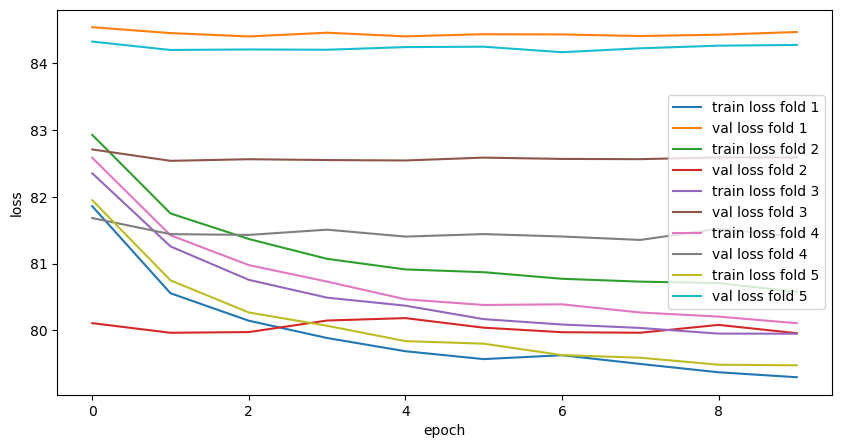

In [159]:
# Perform K-fold validation
loss_history_fold = []
acc_history_fold = []
for fold, (train_index, val_index) in enumerate(kf.split(reshaped_data)):
    print(f"Fold {fold+1}:")

    # Split the data into train and validation sets
    train_dataset = MyDataset(reshaped_data[train_index], df['p_np'].values[train_index])
    val_dataset = MyDataset(reshaped_data[val_index], df['p_np'].values[val_index])

    # Create train and validation data loaders
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    # Define the model
    model = MLP(reshaped_data.shape[1], 128, 1)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Train the model
    (train_losses, val_losses, accuracies) = train(model, train_loader, val_loader, criterion, optimizer, num_epochs=10)

    # Test the model
    test_dataset = MyDataset(reshaped_data[val_index], df['p_np'].values[val_index])
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
    test(model, test_loader)

    print()
    loss_history_fold.append((train_losses, val_losses))
    acc_history_fold.append(accuracies)

# Plot the loss history for all folds
plt.figure(figsize=(10, 5))
for fold, (train_losses, val_losses) in enumerate(loss_history_fold):
    plt.plot(train_losses, label=f"train loss fold {fold+1}")
    plt.plot(val_losses, label=f"val loss fold {fold+1}")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()


In [160]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, device="cpu"):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)

        # Initialize cell state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)

        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))

        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return self.sigmoid(out)

        

In [161]:
def train_LSTM(model, train_loader, val_loader, criterion, optimizer, num_epochs, device="cpu"):
    train_losses = []
    val_losses = []
    accs = []
    model.to(device)

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0

        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)

        for inputs, labels in progress_bar:
            inputs = inputs.to(device).float()
            labels = labels.to(device).float()
            optimizer.zero_grad()
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            progress_bar.set_postfix({"Train Loss": train_loss / (len(progress_bar) + 1)})

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        model.eval()
        val_loss = 0.0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device).float()
                labels = labels.to(device).float()
                outputs = model(inputs).squeeze()
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                accuracy = ((outputs > 0.5) == labels).float().mean()

        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        accs.append(accuracy)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}")
    return train_losses, val_losses , accs

In [162]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
one_hot_dataset = MyDataset(data_one_hot, df['p_np'])
train_dataset_lstm = MyDataset(data_one_hot[:train_size], df['p_np'].values[:train_size])
test_dataset_lstm = MyDataset(data_one_hot[train_size:], df['p_np'].values[train_size:])
train_loader_lstm = DataLoader(train_dataset_lstm, batch_size=32, shuffle=True)
test_loader_lstm = DataLoader(test_dataset_lstm, batch_size=32, shuffle=False)

model = LSTM(len(one_hot_dataset[0][0][2]), 64, 1, 1, device=device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
(train_losses_LSMT, val_losses_LSMT, accuracies_LSMT) = train_LSTM(model, train_loader_lstm, test_loader_lstm, criterion, optimizer, num_epochs=10, device=device)

Epoch 1/10, Train Loss: 76.8512, Val Loss: 109.1140, Accuracy: 1.0000


Epoch 2/10, Train Loss: 76.5900, Val Loss: 109.6339, Accuracy: 0.3077


Epoch 3/10, Train Loss: 75.9668, Val Loss: 110.6429, Accuracy: 0.6154


Epoch 4/10, Train Loss: 76.1769, Val Loss: 109.7368, Accuracy: 0.6538


Epoch 5/10, Train Loss: 76.6275, Val Loss: 108.8923, Accuracy: 1.0000


Epoch 6/10, Train Loss: 76.3362, Val Loss: 109.5966, Accuracy: 0.9615


Epoch 7/10, Train Loss: 76.2454, Val Loss: 109.8945, Accuracy: 0.5769


Epoch 8/10, Train Loss: 76.1914, Val Loss: 109.2255, Accuracy: 0.9615


Epoch 9/10, Train Loss: 76.1583, Val Loss: 109.2962, Accuracy: 0.9615


Epoch 10/10, Train Loss: 76.2384, Val Loss: 109.2955, Accuracy: 0.9615


In [163]:
test(model, test_loader_lstm, device=device)

Test Loss: 109.2955, Accuracy: 0.8878


In [164]:
# Save the model
torch.save(model.state_dict(), "modelLSTM.pth")

Fold 1:


Epoch 1/10:   0%|          | 0/52 [00:00<?, ?it/s, Train Loss=1.57]

Epoch 1/10, Train Loss: 82.3220, Val Loss: 87.0655, Accuracy: 0.9231


Epoch 2/10, Train Loss: 81.8494, Val Loss: 86.9754, Accuracy: 0.8462


Epoch 3/10, Train Loss: 81.3685, Val Loss: 86.8154, Accuracy: 0.9231


Epoch 4/10, Train Loss: 81.0056, Val Loss: 86.7799, Accuracy: 0.9231


Epoch 5/10, Train Loss: 80.8595, Val Loss: 86.7406, Accuracy: 0.9615


Epoch 6/10, Train Loss: 80.7928, Val Loss: 86.7979, Accuracy: 0.9231


Epoch 7/10, Train Loss: 80.6679, Val Loss: 86.9735, Accuracy: 0.9231


Epoch 8/10, Train Loss: 80.8257, Val Loss: 86.5244, Accuracy: 1.0000


Epoch 9/10, Train Loss: 80.6288, Val Loss: 86.5547, Accuracy: 0.9615


Epoch 10/10, Train Loss: 80.5857, Val Loss: 86.4448, Accuracy: 1.0000
Test Loss: 86.4448, Accuracy: 0.8756

Fold 2:


Epoch 1/10, Train Loss: 83.5129, Val Loss: 82.4480, Accuracy: 0.9615


Epoch 2/10, Train Loss: 83.2680, Val Loss: 82.4641, Accuracy: 0.9615


Epoch 3/10, Train Loss: 82.8870, Val Loss: 83.0569, Accuracy: 0.1538


Epoch 4/10, Train Loss: 83.5794, Val Loss: 82.4944, Accuracy: 0.0000


Epoch 5/10, Train Loss: 83.5643, Val Loss: 82.4928, Accuracy: 0.0000


Epoch 6/10, Train Loss: 83.5291, Val Loss: 82.4829, Accuracy: 0.0000


Epoch 7/10, Train Loss: 82.9788, Val Loss: 82.8920, Accuracy: 0.9615


Epoch 8/10, Train Loss: 83.4812, Val Loss: 82.4956, Accuracy: 0.0000


Epoch 9/10, Train Loss: 83.5494, Val Loss: 82.4955, Accuracy: 0.0000


Epoch 10/10, Train Loss: 83.5489, Val Loss: 82.4954, Accuracy: 0.0000
Test Loss: 82.4954, Accuracy: 0.2415

Fold 3:


Epoch 1/10, Train Loss: 83.5851, Val Loss: 81.6065, Accuracy: 0.9615


Epoch 2/10, Train Loss: 83.3957, Val Loss: 81.6246, Accuracy: 0.0769


Epoch 3/10, Train Loss: 83.4383, Val Loss: 81.4211, Accuracy: 1.0000


Epoch 4/10, Train Loss: 83.1075, Val Loss: 81.7012, Accuracy: 0.9615


Epoch 5/10, Train Loss: 82.9215, Val Loss: 81.5911, Accuracy: 1.0000


Epoch 6/10, Train Loss: 83.4543, Val Loss: 81.4779, Accuracy: 1.0000


Epoch 7/10, Train Loss: 83.0448, Val Loss: 81.5372, Accuracy: 1.0000


Epoch 8/10, Train Loss: 82.9031, Val Loss: 81.3568, Accuracy: 1.0000


Epoch 9/10, Train Loss: 83.0365, Val Loss: 81.4148, Accuracy: 0.9615


Epoch 10/10, Train Loss: 82.7095, Val Loss: 81.5335, Accuracy: 0.9231
Test Loss: 81.5335, Accuracy: 0.8171

Fold 4:


Epoch 1/10, Train Loss: 82.9265, Val Loss: 84.5624, Accuracy: 0.9615


Epoch 2/10, Train Loss: 82.7655, Val Loss: 84.5824, Accuracy: 1.0000


Epoch 3/10, Train Loss: 82.1213, Val Loss: 84.2061, Accuracy: 1.0000


Epoch 4/10, Train Loss: 81.9100, Val Loss: 84.5492, Accuracy: 1.0000


Epoch 5/10, Train Loss: 81.6814, Val Loss: 84.2963, Accuracy: 1.0000


Epoch 6/10, Train Loss: 81.5149, Val Loss: 84.0824, Accuracy: 1.0000


Epoch 7/10, Train Loss: 81.4114, Val Loss: 84.0499, Accuracy: 1.0000


Epoch 8/10, Train Loss: 81.4124, Val Loss: 84.0630, Accuracy: 1.0000


Epoch 9/10, Train Loss: 81.2402, Val Loss: 83.9258, Accuracy: 1.0000


Epoch 10/10, Train Loss: 81.3722, Val Loss: 83.8860, Accuracy: 1.0000
Test Loss: 83.8860, Accuracy: 0.8683

Fold 5:


Epoch 1/10, Train Loss: 84.0977, Val Loss: 79.7621, Accuracy: 0.9615


Epoch 2/10, Train Loss: 83.7066, Val Loss: 79.6501, Accuracy: 1.0000


Epoch 3/10, Train Loss: 83.5066, Val Loss: 79.8142, Accuracy: 0.8846


Epoch 4/10, Train Loss: 83.7826, Val Loss: 79.5114, Accuracy: 0.9231


Epoch 5/10, Train Loss: 83.6238, Val Loss: 79.7285, Accuracy: 1.0000


Epoch 6/10, Train Loss: 83.7406, Val Loss: 80.1312, Accuracy: 0.8077


Epoch 7/10, Train Loss: 83.6482, Val Loss: 79.5496, Accuracy: 0.9615


Epoch 8/10, Train Loss: 83.7328, Val Loss: 80.1260, Accuracy: 0.7692


Epoch 9/10, Train Loss: 83.7364, Val Loss: 80.1067, Accuracy: 1.0000


Epoch 10/10, Train Loss: 84.0995, Val Loss: 79.7093, Accuracy: 1.0000
Test Loss: 79.7093, Accuracy: 0.7317



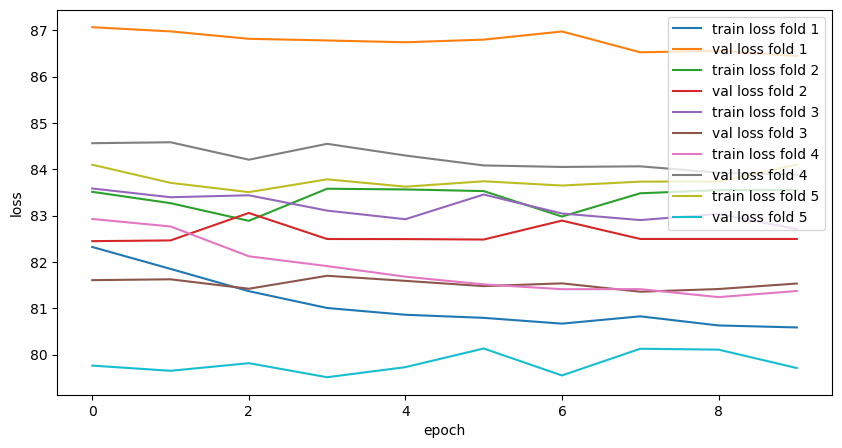

In [165]:
#Perform K-fold validation
loss_history_fold = []
acc_history_fold = []
for fold, (train_index, val_index) in enumerate(kf.split(data_one_hot)):
    print(f"Fold {fold+1}:")

    # Split the data into train and validation sets
    train_dataset = MyDataset(data_one_hot[train_index], df['p_np'].values[train_index])
    val_dataset = MyDataset(data_one_hot[val_index], df['p_np'].values[val_index])

    # Create train and validation data loaders
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    # Define the model
    model = LSTM(len(one_hot_dataset[0][0][2]), 64, 1, 1, device=device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Train the model
    (train_losses, val_losses, accuracies) = train_LSTM(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, device=device)

    # Test the model
    test_dataset = MyDataset(data_one_hot[val_index], df['p_np'].values[val_index])
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
    test(model, test_loader, device=device)

    print()
    loss_history_fold.append((train_losses, val_losses))
    acc_history_fold.append(accuracies)

# Plot the loss history for all folds
plt.figure(figsize=(10, 5))
for fold, (train_losses, val_losses) in enumerate(loss_history_fold):
    plt.plot(train_losses, label=f"train loss fold {fold+1}")
    plt.plot(val_losses, label=f"val loss fold {fold+1}")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()
